In [1]:
import requests
import json
from ES import ES as es
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
import numpy as np

In [2]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("testapp")
sc = SparkContext(conf=conf)

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local") \
    .appName("testapp") \
    .getOrCreate()

In [4]:
sc.version

'2.4.5'

In [5]:
lines = sc.textFile("README.md")
lineLengths = lines.map(lambda s: len(s))
totalLength = lineLengths.reduce(lambda a, b: a + b)

In [6]:
print(lines.take(20))

['# Spark Docker Jupyter', 'This is a readme for this test']


In [7]:
query = {
            "size": 10000,
             "query": {
                "bool": {
                    "must": [
                        {
                            "term": {
                                "enhancement.IDENTIFIERS.SIGNATURE_ID": {
                                    "value": "198"
                                }
                            }
                        },
                        {
                            "range": {
                                "pipeline.lambda": {
                                    "gte": "2019-01-01T00:00:52Z"
                                }
                            }
                        },
                        {
                            "term": {
                                "application_id": {
                                    "value": "3"
                                }
                            }
                        },
                        {
                            "term": {
                                "property_state": {
                                    "value": "CO"
                                }
                            }
                        }
                    ]
                }
             }
        }

In [8]:
db = es()

In [9]:
response = db.get_data_from_ES_prod_scroll(query)

scroll_size: 2852


In [10]:
prop_list = []
for i in range(len(response)):
    for j in range(len(response[i]['hits']['hits'])):
        prop_list.append(response[i]['hits']['hits'][j])

In [11]:
print(len(prop_list))

2852


In [12]:
prop_rdd = sc.parallelize(prop_list)

In [13]:
prop_rdd.count()

2852

In [52]:
def feature_builder(x):
    def cleaner(z):
        return 0 if z is None else z

    prop_lat =      float(cleaner(x.get('_source', {}).get('prop_latitude', 0.0)))
    prop_lon =      float(cleaner(x.get('_source', {}).get('prop_longitude', 0.0)))
    listing_price = float(cleaner(x.get('_source', {}).get('prop_listprice_i', 0.0)))
    sold_price =    float(cleaner(x.get('_source', {}).get('sold_price', 0.0)))
    acres =         float(cleaner(x.get('_source', {}).get('prop_acres', 0.0)))
    year_built =    int(cleaner(x.get('_source', {}).get('prop_yearbuilt', 0)))
    baths =         int(cleaner(x.get('_source', {}).get('total_baths', 0)))
    beds =          int(cleaner(x.get('_source', {}).get('prop_beds', 0)))
#     features_row =  list([prop_lat, prop_lon, listing_price, year_built, baths, beds, acres])
    
    feature_row = Row(
        prop_lat=prop_lat,
        prop_lon=prop_lon,
        sold_price=sold_price,
        year_built=year_built,
        baths=baths,
        beds=beds,
        acres=acres,
        listing_price=listing_price,
#         features=features_row,
        label=sold_price
# #         features=Vectors.dense([prop_lat, prop_lon, listing_price, year_built, baths]),
#         label=Vectors.dense(sold_price)
    )
    return feature_row

In [53]:
prop_feature_rdd = prop_rdd.map(lambda x: feature_builder(x))
prop_feature_rdd.first()
# for r in prop_feature_rdd.first():
#     print(r)

Row(acres=392.0, baths=6, beds=6, label=4348000.0, listing_price=4348000.0, prop_lat=39.762447, prop_lon=-107.145706, sold_price=4348000.0, year_built=2013)

In [54]:
prop_df = spark.createDataFrame(prop_feature_rdd)

In [55]:
prop_df.show()

+-----+-----+----+---------+-------------+---------+-----------+----------+----------+
|acres|baths|beds|    label|listing_price| prop_lat|   prop_lon|sold_price|year_built|
+-----+-----+----+---------+-------------+---------+-----------+----------+----------+
|392.0|    6|   6|4348000.0|    4348000.0|39.762447|-107.145706| 4348000.0|      2013|
| 0.17|    2|   3|      0.0|     321516.0|40.384314|-104.749922|       0.0|      2017|
| 0.18|    3|   4|      0.0|     339500.0|40.348488|-104.715364|       0.0|      2004|
|  3.7|    2|   4|      0.0|     585000.0| 40.44782|-105.045673|       0.0|      1920|
|  0.0|    2|   2|      0.0|     699000.0|40.022659|-105.282547|       0.0|      1984|
| 1.06|    0|   0|      0.0|    1150000.0| 40.18314|-105.103116|       0.0|      1963|
|  0.0|    1|   1|      0.0|     499000.0|40.015093|-105.246062|       0.0|      2007|
| 0.06|    1|   2| 230000.0|     234900.0|39.638392|-106.535293|  230000.0|      1975|
| 0.13|    3|   3| 698000.0|     729000.0|3

In [56]:
clean_prop_df = prop_df.filter(prop_df.sold_price != 0.0).filter(prop_df.year_built != 0).filter(prop_df.beds != 0).filter(prop_df.baths != 0)

In [57]:
clean_prop_df.show()

+-----+-----+----+---------+-------------+---------+-----------+----------+----------+
|acres|baths|beds|    label|listing_price| prop_lat|   prop_lon|sold_price|year_built|
+-----+-----+----+---------+-------------+---------+-----------+----------+----------+
|392.0|    6|   6|4348000.0|    4348000.0|39.762447|-107.145706| 4348000.0|      2013|
| 0.06|    1|   2| 230000.0|     234900.0|39.638392|-106.535293|  230000.0|      1975|
| 0.13|    3|   3| 698000.0|     729000.0|39.622708|-106.497443|  698000.0|      1984|
|35.71|    3|   3| 895000.0|     925000.0|39.677533|-106.663794|  895000.0|      1997|
| 0.13|    4|   3| 660000.0|     660000.0| 39.62446| -106.50794|  660000.0|      1982|
| 0.04|    5|   4| 990000.0|     999000.0|39.649049|-106.609876|  990000.0|      2004|
| 0.05|    2|   2| 315000.0|     325000.0|39.636234|-106.537857|  315000.0|      1980|
| 0.15|    3|   4| 495000.0|     495000.0|39.647409|-106.830977|  495000.0|      1993|
| 0.01|    3|   3|2100000.0|    2275000.0|3

In [58]:
clean_prop_df.count()

2197

In [59]:
clean_prop_df.describe(['acres', 'baths', 'beds', 'sold_price', 'year_built']).show()

+-------+------------------+------------------+------------------+-----------------+------------------+
|summary|             acres|             baths|              beds|       sold_price|        year_built|
+-------+------------------+------------------+------------------+-----------------+------------------+
|  count|              2197|              2197|              2197|             2197|              2197|
|   mean|1.2998188438780152| 3.090578060992262| 3.416021847974511|613095.4082840236|1989.8702776513428|
| stddev|13.924289322070507|1.3242475551682544|1.1542579822137828|741892.2958216049| 22.05257450750853|
|    min|               0.0|                 1|                 1|            895.0|              1888|
|    max|             392.0|                11|                 9|           1.35E7|              2019|
+-------+------------------+------------------+------------------+-----------------+------------------+



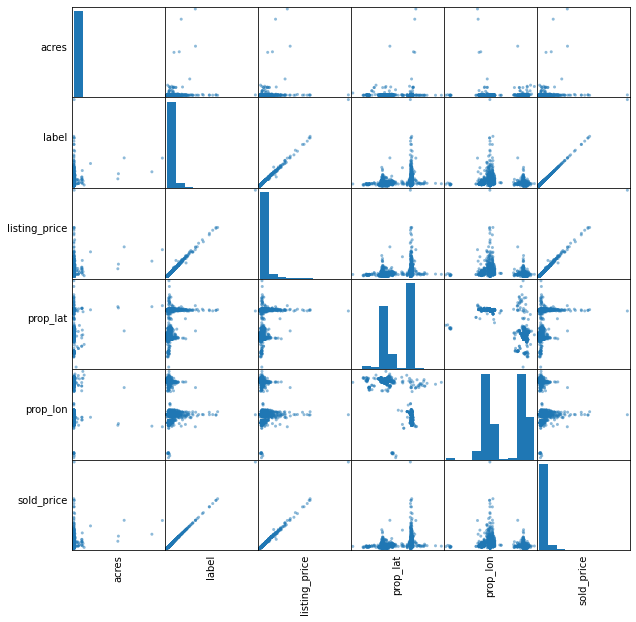

In [60]:
import pandas as pd
numeric_features = [t[0] for t in clean_prop_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = clean_prop_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [68]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(
    inputCols = ['prop_lat', 'prop_lon', 'listing_price', 'year_built', 'baths', 'beds', 'acres'], 
    outputCol = 'features')
feature_label_df = vectorAssembler.transform(clean_prop_df)
# feature_label_df = feature_label_df.select(['features', 'label'])
feature_label_df.show(3)

+-----+-----+----+---------+-------------+---------+-----------+----------+----------+--------------------+
|acres|baths|beds|    label|listing_price| prop_lat|   prop_lon|sold_price|year_built|            features|
+-----+-----+----+---------+-------------+---------+-----------+----------+----------+--------------------+
|392.0|    6|   6|4348000.0|    4348000.0|39.762447|-107.145706| 4348000.0|      2013|[39.762447,-107.1...|
| 0.06|    1|   2| 230000.0|     234900.0|39.638392|-106.535293|  230000.0|      1975|[39.638392,-106.5...|
| 0.13|    3|   3| 698000.0|     729000.0|39.622708|-106.497443|  698000.0|      1984|[39.622708,-106.4...|
+-----+-----+----+---------+-------------+---------+-----------+----------+----------+--------------------+
only showing top 3 rows



In [69]:
splits = feature_label_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [70]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [4940.169252920892,3410.959108838698,0.9434665350895698,168.13691454183294,2422.7962516603525,-5379.949949418512,0.0]
Intercept: -143136.6672354236


In [71]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 56998.179109
r2: 0.994625


In [73]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","label","features").show(10)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+---------+--------------------+
|        prediction|    label|            features|
+------------------+---------+--------------------+
|  262375.050589139| 249000.0|[39.658067,-106.8...|
|1152218.5798215189|1150000.0|[39.639105,-106.3...|
|25919.242987342266|   1400.0|[38.925151,-104.7...|
| 94243.47308187565|  79000.0|[39.650573,-106.6...|
| 2175217.305567562|2070000.0|[39.644139,-106.3...|
| 66599.78137049341|  52000.0|[38.903907,-104.7...|
| 299145.0665157201| 287000.0|[39.604448,-106.5...|
| 654142.0834904027| 650000.0|[39.640386,-106.3...|
| 430169.8131273844| 425000.0|[39.633002,-106.5...|
|  665890.116438758| 679900.0|[39.60471,-106.51...|
+------------------+---------+--------------------+
only showing top 10 rows

R Squared (R2) on test data = 0.995987


In [75]:
lr_predictions.select("listing_price", "label", "prediction").show()

+-------------+---------+------------------+
|listing_price|    label|        prediction|
+-------------+---------+------------------+
|     254000.0| 249000.0|  262375.050589139|
|    1200000.0|1150000.0|1152218.5798215189|
|       1400.0|   1400.0|25919.242987342266|
|      85000.0|  79000.0| 94243.47308187565|
|    2280000.0|2070000.0| 2175217.305567562|
|      48900.0|  52000.0| 66599.78137049341|
|     295000.0| 287000.0| 299145.0665157201|
|     675000.0| 650000.0| 654142.0834904027|
|     429900.0| 425000.0| 430169.8131273844|
|     679900.0| 679900.0|  665890.116438758|
|     155000.0| 155000.0|167363.49002511412|
|     569000.0| 527500.0| 561308.4460376228|
|     108000.0| 112000.0|123699.68194806835|
|      99750.0| 102750.0| 116405.4115602599|
|     172000.0| 173000.0|184472.14540125776|
|     250000.0| 243000.0|253238.14847589706|
|     369000.0| 365000.0| 366707.3764668843|
|     370000.0| 350000.0|370886.84698054777|
|     162900.0| 165000.0|173186.21783690268|
|     2990

In [83]:
data = lr_predictions.select("listing_price", "label", "prediction").collect()

In [99]:
data_dicts = [r.asDict() for r in data]

In [101]:
def per_diff(x):
    return abs(x['label']-x['prediction'])*100.0/x['label']
for d in data_dicts:
    d['per_diff'] = per_diff(d)

In [104]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

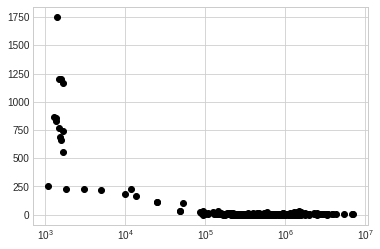

In [106]:
x = [d['listing_price'] for d in data_dicts]
y = [d['per_diff'] for d in data_dicts]

plt.semilogx(x, y, 'o', color='black');